In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wd
from ipywidgets import interact
import seaborn as sns
import ptitprince as pt
import re #I import this library 'cause I need to deal with regular expressions
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer # para usar Yeo-Johnson
from scipy.stats import skew


In [2]:
mergedDataBaseFile="Merged_DB.csv"
merged=pd.read_csv(mergedDataBaseFile)

In [3]:
merged['has_transitions'].dtype

dtype('bool')

In [4]:
merged.columns

Index(['id_band', 'score', 'has_transitions', 'albumCount', 'review_count'], dtype='object')

## Tabla de contenidos
1. [El Viaje Musical y su Impacto en la Reputacion](#El-Viaje-Musical-y-su-Impacto-en-la-Reputacion)
    1. [Punto de Partida: Una Base de Datos Unificada](#Punto-de-Partida:-Una-Base-de-Datos-Unificada)
    2. [Integracion de Datos Externos: La Voz del Publico](#Integracion-de-Datos-Externos:-La-Voz-del-Publico)
    3. [Transiciones de Genero: La Busqueda de la Autenticidad](#Transiciones-de-Genero:-La-Busqueda-de-la-Autenticidad)
2. [Data Wrangling adicional en la nueva db](#Data-Wrangling-adicional-en-la-nueva-db)
    1. [Deteccion y tratamiento de outliers](#Deteccion-y-tratamiento-de-outliers)
    2. [Observaciones preliminares de los dos escenarios (hay transiciones y no las hay)](#Observaciones-preliminares-de-los-dos-escenarios-(hay-transiciones-y-no-las-hay))
    3. [Tratamiento de los outliers por medio del Z score](#Tratamiento-de-los-outliers-por-medio-del-Z-score)
    4. [Tratamiento de outliers por IQR](#Tratamiento-de-outliers-por-IQR)
    5. [Variaciones en la media y mediana luego de la limpieza con Z Score e IQR](#Variaciones-en-la-media-y-mediana-luego-de-la-limpieza-con-Z-Score-e-IQR)
3. [One hot encoding para el feature "has transitions"](#One-hot-encoding-para-el-feature-"has-transitions")



# El Viaje Musical y su Impacto en la Reputación

En el vasto universo de la música, el cambio es constante. Las bandas evolucionan, adaptan sus estilos y experimentan con nuevos géneros. Pero, ¿qué impacto tiene realmente esta evolución en cómo perciben los fans a estas bandas?

## Punto de Partida: Una Base de Datos Unificada

Comenzamos con una base de datos unificada que consolida información sobre múltiples bandas y sus trayectorias musicales. Sin embargo, para obtener una visión más completa, necesitábamos algo más. Necesitábamos entender la opinión del público: esos aficionados apasionados que compran álbumes, asisten a conciertos y, en la era moderna, dejan sus opiniones en línea.

## Integración de Datos Externos: La Voz del Público

Para añadir esta dimensión crucial, nos sumergimos en el vasto océano de datos de Amazon. A través de un proceso de scraping, obtuvimos un tesoro: las reseñas de los discos de estas bandas. Estas reseñas, escritas por personas comunes que consumen su música, nos dieron el conteo de veces que cada disco fue reseñado, proporcionándonos un indicador del impacto y alcance de cada banda en el público.

Con esta nueva información en mano, pudimos calcular un "valor emergente" para cada banda: el valor promedio de las calificaciones de todos los discos de las bandas hasta la fecha respectiva. Esta métrica nos dio una idea más precisa del posicionamiento y reputación de una banda en un momento dado.

## Transiciones de Género: La Búsqueda de la Autenticidad

Con nuestro conjunto de datos enriquecido, nos aventuramos a responder una pregunta intrigante: ¿Qué sucede cuando una banda decide hacer una transición de género musical, en particular, moviéndose del death metal a otros géneros, o viceversa? O, ¿qué pasa cuando deciden mantenerse fieles a su género original?

Para visualizar y entender mejor estas dinámicas, recurrimos a los "raincloud plots" del score. Estos gráficos nos permitieron comparar las distribuciones de los scores entre las bandas que experimentaron con transiciones de género y aquellas que se mantuvieron firmes en su estilo original.




# Data Wrangling adicional en la nueva db
Con el objetivo de empezar a responder preguntas acerca del estudio de las puntuaciones críticas obtenidas por las bandas en función de los features 
"tiene transciones" (has_transitions) el cual da cuenta de si la banda cambio de género entre el death metal y otros géneros, "conteo de discos" (albumCount) y conteo de reseñas (review_count), procedo como primer paso a estudiar la forma de la distrubución de los datos primero en términos de la variable booleana

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


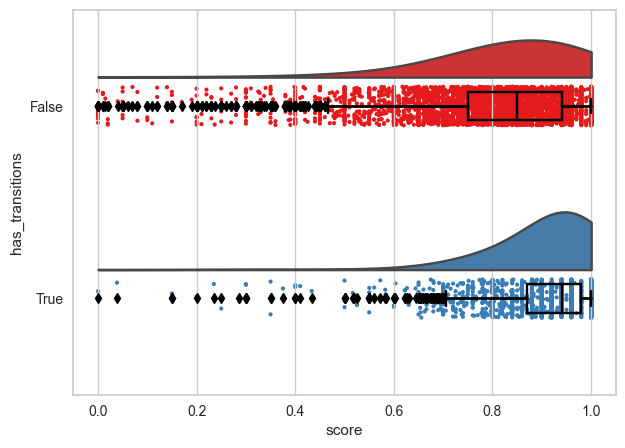

In [5]:
transitionsDF=merged[['has_transitions','score']]

f, ax=plt.subplots(figsize=(7,5))
dy="has_transitions"; dx="score"; ort="h";pal="Set1"

ax=pt.half_violinplot(x=dx,y=dy,data=transitionsDF,palette=pal,bw=.6,cut=0.,scale="area",width= .6,inner=None,orient=ort)

ax=sns.stripplot( x = dx, y = dy, data = transitionsDF, palette = pal,
 edgecolor = "white", size = 3, jitter = 1, zorder = 0,
 orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = transitionsDF, color = "black", 
 width = .15, zorder = 10, showcaps = True,
 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
 whiskerprops = {'linewidth':2, "zorder":10},
 saturation = 1, orient = ort)

ax.legend(loc='upper left')
plt.savefig('original_dist.png')
plt.show()

## Detección y tratamiento de outliers

Para hacer la detección y tratamiento de los datos atípicos o outliers en el proyecto se entra a considerar dos acercamientos: el primero consiste en calcular el z score de los datos del feature "score" con el fin de observar el efecto en las medidas de tendencia central de este feature dado el volumen de datos atípicos concentrado en la cola de la distribución hacia calificaciones bajas de los discos producidos por las bandas de metal, lo cual es llamativo sobre todo cuando estos se concentran muy cerca a calificaciones muy bajas. 

## Observaciones preliminares de los dos escenarios (hay transiciones y no las hay)

En el caso en el cual las bandas no han efectuado cambios de género, es decir han permanecido haciendo Death Metal de forma consistente se observa una media más alta en la calificación de los discos que en el caso en el cual la banda experimenta transiciones de género; sin embargo, la mediana es mucho mayor en el caso en este mismo escenario respecto al caso en el cual las bandas permanecen haciendo de forma consistente Death Metal; asimismo, se observan calificaciones más bajas de forma regular en las bandas que no se aventuran a hacer algo diferente al Death Metal que en las que si se arriesgan a experimentar con introducir o probar nuevos sonidos

In [6]:
TrueMean=transitionsDF.loc[transitionsDF['has_transitions']==True]['score'].mean()
TrueMedian=transitionsDF.loc[transitionsDF['has_transitions']==True]['score'].median()
FalseMean=transitionsDF.loc[transitionsDF['has_transitions']==False]['score'].mean()
FalseMedian=transitionsDF.loc[transitionsDF['has_transitions']==False]['score'].median()
print(f"la media de transiciones verdaderas es {TrueMean} y la mediana es {TrueMedian} y en el caso de las transciones en falso la media es {FalseMean} y la mediana es {FalseMedian}")

la media de transiciones verdaderas es 0.9041948579387051 y la mediana es 0.94 y en el caso de las transciones en falso la media es 0.824935069147989 y la mediana es 0.85


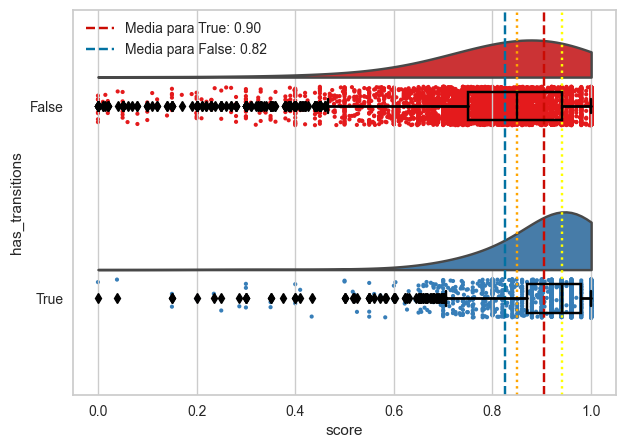

In [7]:
f, ax = plt.subplots(figsize=(7,5))
dy = "has_transitions"; dx = "score"; ort = "h"; pal = "Set1"

ax = pt.half_violinplot(x=dx, y=dy, data=transitionsDF, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort)
ax = sns.stripplot(x=dx, y=dy, data=transitionsDF, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort)
ax = sns.boxplot(x=dx, y=dy, data=transitionsDF, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops={'linewidth':2, "zorder":10}, saturation=1, orient=ort)


ax.axvline(TrueMean, color='r', linestyle='--', label=f'Media para True: {TrueMean:.2f}')
ax.axvline(FalseMean, color='b', linestyle='--', label=f'Media para False: {FalseMean:.2f}')

ax.axvline(TrueMedian, color='yellow', linestyle=':')
ax.axvline(FalseMedian, color='orange', linestyle=':')

# Mostrar leyenda
ax.legend(loc='upper left')

plt.show()


## Tratamiento de los outliers por medio del Z score

Una vez detectado que existen datos con calificaciones inusualmente bajas que pueden corresponder a resultados poco probables para la calificación media de los discos de una banda que tiene una trayectoria dada, se procede a imputar los datos usando la mediana ya que la distribución no es simétrica y tiene una cola hacia la izquierda y se elige usar una función para reemplazar esos valores atípicos por esta medida de tendencia central y posteriormente comparar con el filtrado de outliers por IQR

In [8]:
def zScoreFilter(df,col):
    df_copy = df.copy()
    zScore=(df_copy[col]-df_copy[col].mean())/df_copy[col].std()
    filtro=(zScore>3)|(zScore<-3)
    df_copy[col] = df_copy[col].where(~filtro, np.nan)
    median = df_copy[col].median()
    df_copy[col].fillna(median, inplace=True)
   
    return df_copy

In [9]:
mergedZScore=zScoreFilter(merged,'score')

In [10]:
zScoreDF=mergedZScore[['has_transitions','score']]
zScoreTrueMean=zScoreDF.loc[zScoreDF['has_transitions']==True]['score'].mean()
zScoreTrueMedian=zScoreDF.loc[zScoreDF['has_transitions']==True]['score'].median()
zScoreFalseMean=zScoreDF.loc[zScoreDF['has_transitions']==False]['score'].mean()
zScoreFalseMedian=zScoreDF.loc[zScoreDF['has_transitions']==False]['score'].median()
print(f"la media de transiciones verdaderas es {zScoreTrueMean} y la mediana es {zScoreTrueMedian} y en el caso de las transciones en falso la media es {zScoreFalseMean} y la mediana es {zScoreFalseMedian}")

la media de transiciones verdaderas es 0.909178179452639 y la mediana es 0.94 y en el caso de las transciones en falso la media es 0.8375390257789274 y la mediana es 0.86


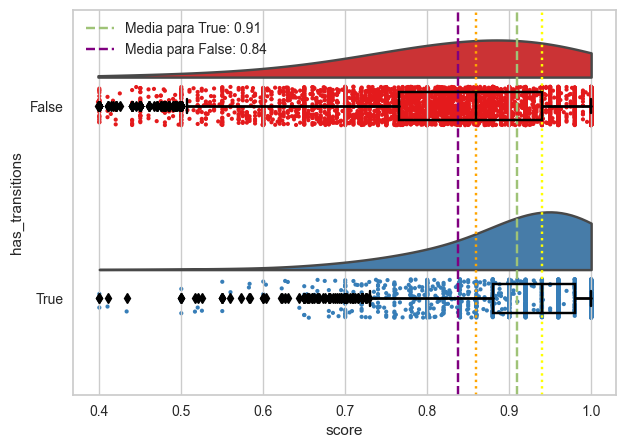

In [11]:
f, ax = plt.subplots(figsize=(7,5))
dy = "has_transitions"; dx = "score"; ort = "h"; pal = "Set1"

ax = pt.half_violinplot(x=dx, y=dy, data=zScoreDF, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort)
ax = sns.stripplot(x=dx, y=dy, data=zScoreDF, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort)
ax = sns.boxplot(x=dx, y=dy, data=zScoreDF, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops={'linewidth':2, "zorder":10}, saturation=1, orient=ort)


ax.axvline(zScoreTrueMean, color='g', linestyle='--', label=f'Media para True: {zScoreTrueMean:.2f}')
ax.axvline(zScoreFalseMean, color='purple', linestyle='--', label=f'Media para False: {zScoreFalseMean:.2f}')

ax.axvline(zScoreTrueMedian, color='yellow', linestyle=':')
ax.axvline(zScoreFalseMedian, color='orange', linestyle=':')

# Mostrar leyenda
ax.legend(loc='upper left')
plt.savefig('zscore.png')
plt.show()

## Tratamiento de outliers por IQR

In [12]:
def outliersFilter(df, col):
    df_copy = df.copy()
    
    Q1 = df_copy[col].quantile(0.25)
    Q3 = df_copy[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (df_copy[col] < (Q1 - 1.5 * IQR)) | (df_copy[col] > (Q3 + 1.5 * IQR))
    df_copy[col] = df_copy[col].where(~filtro, np.nan)
    median = df_copy[col].median()
    df_copy[col].fillna(median, inplace=True)
    
    return df_copy


In [13]:
mergedResult=outliersFilter(merged,'score')

In [14]:
noOutliersDF=mergedResult[['has_transitions','score']]
FilterTrueMean=noOutliersDF.loc[noOutliersDF['has_transitions']==True]['score'].mean()
FilterTrueMedian=noOutliersDF.loc[noOutliersDF['has_transitions']==True]['score'].median()
FilterFalseMean=noOutliersDF.loc[noOutliersDF['has_transitions']==False]['score'].mean()
FilterFalseMedian=noOutliersDF.loc[noOutliersDF['has_transitions']==False]['score'].median()
print(f"la media de transiciones verdaderas es {FilterTrueMean} y la mediana es {FilterTrueMedian} y en el caso de las transciones en falso la media es {FilterFalseMean} y la media es {FilterFalseMedian}")

la media de transiciones verdaderas es 0.9112410586583752 y la mediana es 0.94 y en el caso de las transciones en falso la media es 0.8487282209093834 y la media es 0.87


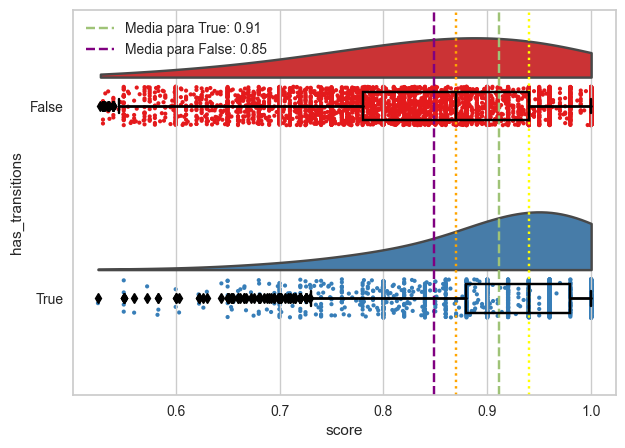

In [15]:
f, ax = plt.subplots(figsize=(7,5))
dy = "has_transitions"; dx = "score"; ort = "h"; pal = "Set1"

ax = pt.half_violinplot(x=dx, y=dy, data=noOutliersDF, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort)
ax = sns.stripplot(x=dx, y=dy, data=noOutliersDF, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort)
ax = sns.boxplot(x=dx, y=dy, data=noOutliersDF, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops={'linewidth':2, "zorder":10}, saturation=1, orient=ort)


ax.axvline(FilterTrueMean, color='g', linestyle='--', label=f'Media para True: {FilterTrueMean:.2f}')
ax.axvline(FilterFalseMean, color='purple', linestyle='--', label=f'Media para False: {FilterFalseMean:.2f}')

ax.axvline(FilterTrueMedian, color='yellow', linestyle=':')
ax.axvline(FilterFalseMedian, color='orange', linestyle=':')

# Mostrar leyenda
ax.legend(loc='upper left')
plt.savefig('IQR.png')
plt.show()

## Variaciones en la media y mediana luego de la limpieza con Z Score e IQR

In [16]:
varIQRMean=round((abs(FilterTrueMean-TrueMean)/TrueMean)*100,1)
varIQRMedian=round((abs(FilterTrueMedian-TrueMedian)/TrueMedian)*100,1)
varZSCOREMean=round((abs(zScoreTrueMean-TrueMean)/TrueMean)*100,1)
varZSCOREMedian=round((abs(zScoreTrueMedian-TrueMedian)/TrueMedian)*100,1)
varIQRMeanF=round((abs(FilterFalseMean-FalseMean)/FalseMean)*100,1)
varIQRMedianF=round((abs(FilterFalseMedian-FalseMedian)/FalseMedian)*100,1)
varZSCOREMeanF=round((abs(zScoreFalseMean-FalseMean)/FalseMean)*100,1)
varZSCOREMedianF=round((abs(zScoreFalseMedian-FalseMedian)/FalseMedian)*100,1)
f"Las variaciones porcentuales de la media y mediana para el caso de los valores True, son, respectivamente usando filtrado por IQR son de {varIQRMean}% y {varIQRMedian}%. Por otro lado, las variaciones porcentuales de la media y mediana son, respectivamente usando filtrado por ZScore son de {varZSCOREMean}% y {varZSCOREMedian}% y para el caso de False, son, respectivamente usando filtrado por IQR son de {varIQRMeanF}% y {varIQRMedianF}%. Por otro lado, las variaciones porcentuales de la media y mediana son, respectivamente usando filtrado por ZScore son de {varZSCOREMeanF}% y {varZSCOREMedianF}%"



'Las variaciones porcentuales de la media y mediana para el caso de los valores True, son, respectivamente usando filtrado por IQR son de 0.8% y 0.0%. Por otro lado, las variaciones porcentuales de la media y mediana son, respectivamente usando filtrado por ZScore son de 0.6% y 0.0% y para el caso de False, son, respectivamente usando filtrado por IQR son de 2.9% y 2.4%. Por otro lado, las variaciones porcentuales de la media y mediana son, respectivamente usando filtrado por ZScore son de 1.5% y 1.2%'

# One hot encoding para el feature "has transitions" 
Con el objetivo de hacer un one hot encoding con la columna del booleano "has transitions" y aprovechando su caracter booleano solo cambio el tipo de dato a entero, de manera que los True se vuelven 1

In [17]:
mlDB=merged.copy()

In [18]:
mlDB['has_transitions']=mlDB['has_transitions'].astype(int)

In [19]:
mlDB

,id_band,score,has_transitions,albumCount,review_count
0,11143,0.500000,1,1.0,1
1,14768,0.770000,1,1.0,1
2,16693,0.860000,1,2.0,1
3,16950,0.783333,1,1.0,1
4,20572,0.550000,1,3.0,1
...,...,...,...,...,...
8090,51016,0.700000,1,1.0,4
8091,56642,0.700000,1,1.0,4
8092,60904,0.680000,0,1.0,6
8093,40786,0.680000,0,1.0,6


In [20]:
merged['albumCount'].max()

17.0

# Tratamiento de outliers usando la transformación de Yeo-Johnson

Debido a que la distribución de datos observada para los datos asociados al score de las bandas presenta un evidente sesgo hacia la izquierda, el proceder a normalizar los datos con un standar scaler o robust scaler puede llevar a interpretar erroneamente datos como outliers, por lo que se procede a usar la transformación de Yeo-Johnson para verificar los datos atipicos y luego comparar los resultados obtenidos con los analizados por IQR



In [21]:
mergedYeo=merged.copy()

In [22]:
data = mergedYeo['score'].values.reshape(-1, 1)
powerT = PowerTransformer(method='yeo-johnson')
mergedYeo[['score_yj']] = powerT.fit_transform(mergedYeo[['score']])


In [23]:
yeoDF=mergedYeo.copy()

In [24]:
# Calcular la media
mean = np.mean(mergedYeo['score_yj'])

# Calcular la mediana
median = np.median(mergedYeo['score_yj'])

# Calcular la varianza
variance = np.var(mergedYeo['score_yj'])

# Calcular la asimetría
data_skew = skew(mergedYeo['score_yj'])

# Imprimir los resultados
print("Media:", mean)
print("Mediana:", median)
print("Varianza:", variance)
print("Asimetría:", data_skew)

Media: 0.0
Mediana: 0.0771036148614697
Varianza: 1.0000000000000002
Asimetría: -0.21149136633803056


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


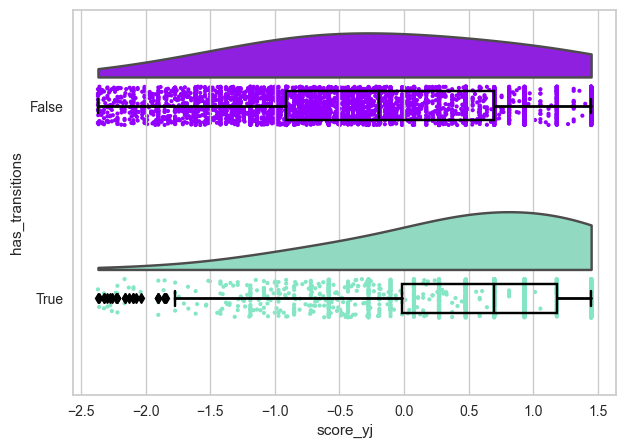

In [37]:
transitionsYeo=yeoDF[['has_transitions','score_yj']]

f, ax=plt.subplots(figsize=(7,5))
dy="has_transitions"; dx="score_yj"; ort="h";pal = ["#9400FF", "#85E6C5"]


ax=pt.half_violinplot(x=dx,y=dy,data=yeoDF,palette=pal,bw=.6,cut=0.,scale="area",width= .6,inner=None,orient=ort)

ax=sns.stripplot( x = dx, y = dy, data = yeoDF, palette = pal,
 edgecolor = "white", size = 3, jitter = 1, zorder = 0,
 orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = yeoDF, color = "black", 
 width = .15, zorder = 10, showcaps = True,
 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
 whiskerprops = {'linewidth':2, "zorder":10},
 saturation = 1, orient = ort)

ax.legend(loc='upper left')
#plt.savefig('original_dist.png')
plt.show()

In [26]:
def outliersMarker(df, col1, col2):
    df_copy = df.copy()
    
    # Procesamiento para col1
    Q1_col1 = df_copy[col1].quantile(0.25)
    Q3_col1 = df_copy[col1].quantile(0.75)
    IQR_col1 = Q3_col1 - Q1_col1
    filtro_col1 = (df_copy[col1] < (Q1_col1 - 1.5 * IQR_col1)) | (df_copy[col1] > (Q3_col1 + 1.5 * IQR_col1))
    df_copy[col1] = df_copy[col1].where(~filtro_col1, np.nan)
    
    # Procesamiento para col2
    Q1_col2 = df_copy[col2].quantile(0.25)
    Q3_col2 = df_copy[col2].quantile(0.75)
    IQR_col2 = Q3_col2 - Q1_col2
    filtro_col2 = (df_copy[col2] < (Q1_col2 - 1.5 * IQR_col2)) | (df_copy[col2] > (Q3_col2 + 1.5 * IQR_col2))
    df_copy[col2] = df_copy[col2].where(~filtro_col2, np.nan)
    
    return df_copy


In [27]:
yeoOutliers=outliersMarker(yeoDF,'score','score_yj')

In [28]:
yeoOutliers

,id_band,score,has_transitions,albumCount,review_count,score_yj
0,11143,NaN,True,1.0,1,-1.902681
1,14768,0.770000,True,1.0,1,-0.787386
2,16693,0.860000,True,2.0,1,-0.104543
3,16950,0.783333,True,1.0,1,-0.698906
4,20572,0.550000,True,3.0,1,-1.772381
...,...,...,...,...,...,...
8090,51016,0.700000,True,1.0,4,-1.189858
8091,56642,0.700000,True,1.0,4,-1.189858
8092,60904,0.680000,False,1.0,6,-1.287557
8093,40786,0.680000,False,1.0,6,-1.287557


In [29]:
yeoOutliers[yeoOutliers['score_yj'].isna()]

,id_band,score,has_transitions,albumCount,review_count,score_yj


In [30]:
filtered_rows = yeoOutliers[(yeoOutliers['has_transitions'] == True) & (yeoOutliers['score'].isna())]


In [31]:
filtered_rows

,id_band,score,has_transitions,albumCount,review_count,score_yj
0,11143,NaN,True,1.0,1,-1.902681
26,35746,NaN,True,3.0,1,-2.231756
67,37115,NaN,True,1.0,1,-2.219113
73,37148,NaN,True,2.0,1,-2.131401
88,37195,NaN,True,1.0,1,-2.323092
93,37207,NaN,True,3.0,1,-2.039659
108,37272,NaN,True,1.0,1,-2.323092
111,37277,NaN,True,1.0,1,-2.370062
132,37395,NaN,True,1.0,1,-2.296699
147,37469,NaN,True,1.0,1,-2.164032
